In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
#from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from IPython.display import clear_output
from typing import NamedTuple
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()


try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

pd.set_option('max_row', None)
pd.set_option('max_column', None)


class SinglePeriod:
    def __init__(
        self, 
        data,  
        preds, 
        budget, 
        init_budget,
        share_budget,
        sampler, 
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):
    
        self.df = data
        self.preds = preds
        self.budget = budget
        self.share_budget = share_budget
        self.init_budget = init_budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.stocks = self.df.columns.tolist()
        
        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        # if sampler_args:
        #     self.sampler_args = json.loads(str(sampler_args))
        # else:
        #     self.sampler_args = {}

        #self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.sampler = sampler
        self.solution = {}
        self.precision = 2

        self.list_dates = self.df.index.values

    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        print(f'idx: {idx}')
        #print(f'self.df.loc: {self.df.loc[idx,:]}')
        self.max_num_shares = (self.share_budget/self.df.loc[idx,:]).astype(int)
        #print(f'max_num_shares: {self.max_num_shares}')
        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}
        #print(f'x: {x}')
        
        #print(f'self.df')
        #display(self.df.head())
        #print(f'self.df.index.values: {self.df.index.values}')
        #print(f'self.list_dates: {self.list_dates}')
        self.position = np.where(self.list_dates == idx)[0][0]
        print(f'self.position: {self.position}')
        #self.position2 = np.where(self.list_dates == idx)[0]
        #print(f'self.position 2: {self.position2}')
        self.initial_position = self.list_dates[self.position-5]
        print(f'self.initial_position: {self.initial_position}')
        #print('self.df')
        #display(self.df)
        self.price = self.df.loc[idx, :]
        print(f'sum price: {self.price.sum()}')
        #print(f'price: {self.price}')
        #print(self.price)
        self.pct_returns = self.df.pct_change()
        self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        #self.daily_returns = self.pct_returns.loc[self.initial_position:idx, :]
        print(f'sum daily returns: {self.daily_returns.stack().sum()}')
        #self.avg_daily_returns = self.daily_returns.rolling(window=1).mean().loc[idx,:]
        self.avg_daily_returns = self.preds
        print(f'avg daily returns: {self.avg_daily_returns.sum()}')
        # print('avg daily returns 2')
        # display(self.avg_daily_returns2.head())
        self.covariance_matrix = self.daily_returns.cov()
        self.correlation_matrix = self.daily_returns.corr()
        #print('cov matrix')
        #display(self.covariance_matrix.head())
        print(f'covariance_matrix sum: {self.covariance_matrix.stack().sum()}')
        #print('corr matrix')
        #display(self.correlation_matrix.head())
        print(f'correlation_matrix sum: {self.correlation_matrix.stack().sum()}')

        
        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]       
        #print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]
        #print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            #print(f'self.init_holdings: {self.init_holdings}')
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0

            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')
            print(f'upper bound = budget: {self.budget}')
            print(f'init_budget: {self.init_budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')
            #print(f'lhs: {lhs}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')

           
        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            #print('cqm debugging')
            #print(f'risk: {type(risk)}')
            #print(f'returns: {returns}')
            #print(f'objective: {self.alpha*risk - returns}')

            cqm.set_objective(self.alpha*risk - returns)
            #cqm.set_objective(-1*returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm

    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:        
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            #print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        sum_solution = 0
        for s1 in solution:
            #print(f's1: {s1}, {solution[s1]}, price: {self.price[s1]}')
            sum_solution += solution[s1]
            #print(f'covariance matrix: {self.covariance_matrix[s1].sum()}')

        print(f'MMM price: {self.price["MMM"]}, solution: {solution["MMM"]}')
        print(f'sum price: {sum(self.price)}')
        print(f'sum solution: {sum_solution}')

        variance = 0.0
        for s1, s2 in product(solution, solution):
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        for stock in solution:
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self, 
                data, 
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):
    
        self.save_path = save_path
        self.df = data
        self.stocks = self.df.columns.values.tolist()
        self.stocks = sorted(self.stocks)

        
        self.sampler_args = sampler_args
        self.budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type
        
        initial_gspc = self.baseline.query('Date==@dates[0]').values.tolist()[0][0]
        #print('initial baseline')
        #display(self.baseline)
        #print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        self.init_budget = budget
        #print('final baseline')
        #display(self.baseline)
        #print('initial data')
        #display(self.df.head())

        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}

        print('iniital_holdings')
        print(self.init_holdings)
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = sorted(self.stocks)
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}
        # self.sample_set = {}
        # self.sampler_args = sampler_args
        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}

        self.solution = {}
        
    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """
        
        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []
        
        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'returns', 'value'])
        #row = []
        

        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')
            df_train = self.df.loc[:idx, :]
            #print('df train')
            #display(df_train.head())
            self.preds = predict_returns(df_train)
            self.price = self.df.loc[idx, :]
            baseline_current = self.baseline.loc[idx, :]
            # single_period = SinglePeriod(data=self.df, 
            #                              preds=self.preds.pct_change().iloc[-1,:], 
            #                              budget=self.budget, 
            #                              init_budget = self.init_budget,
            #                              sampler_args=self.sampler_args, 
            #                              dates=self.dates,
            #                              model_type=self.model_type,
            #                              alpha=self.alpha,
            #                              verbose=self.verbose,
            #                              t_cost=self.t_cost,
            #                              label=self.label,
            #                              init_holdings=self.init_holdings)

            if first_purchase:
                print(f'first purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                # single_period = SinglePeriod(data=self.df, 
                #                          preds=self.preds.pct_change().iloc[-1,:], 
                #                          budget=self.budget, 
                #                          init_budget = self.init_budget,
                #                          sampler_args=self.sampler_args, 
                #                          dates=self.dates,
                #                          model_type=self.model_type,
                #                          alpha=self.alpha,
                #                          verbose=self.verbose,
                #                          t_cost=self.t_cost,
                #                          label=self.label,
                #                          init_holdings=self.init_holdings)
                initial_budget = self.budget
                self.share_budget = self.budget
                
                baseline_shares = (self.budget / baseline_current)
                #display(self.baseline)
                #self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
                #self.init_holdings = self.solution['stocks']
                #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            else:
                #self.budget = sum([self.df.iloc[-1][s]*self.solution['stocks'][s] for s in self.stocks])
                self.share_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            # Set budget to 0 to enforce that portfolio is self-financing
                if self.t_cost and not first_purchase:
                    #self.budget = 1
                    self.budget = 0.0
                    #self.budget = self.init_budget
                print(f'new purchase budget: {self.budget}, initial_budget: {self.init_budget}')
                
                
                # if self.t_cost and not first_purchase:
                #     self.budget = 0
            
            single_period = SinglePeriod(data=self.df, 
                                            preds=self.preds.pct_change().iloc[-1,:], 
                                            budget=self.budget, 
                                            init_budget = self.init_budget,
                                            share_budget = self.share_budget,
                                            sampler=self.sampler, 
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            
            
            #print(f'budget before calculation: {self.budget}, initial_budget: {initial_budget}')
            #print(f'init_holdings before calculation: {self.init_holdings}')
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            #self.init_budget = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'final budget: {sum([self.price[s]*self.solution["stocks"][s] for s in self.stocks])}')
            #print(f'init_holdings after calculation: {self.init_holdings}')

            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            print(f'sum shares: {sum([self.solution["stocks"][s] for s in self.stocks])}')
            returns = self.solution['return']
            variance = self.solution['risk']

            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'returns': returns, 'value': value}])])
            
            first_purchase = False

            #clear_output(wait=True)
            initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / initial_budget - 1
            display(self.agg_results)
            
            fig = plt.figure(figsize=(10.708,8.2))
            sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            plt.show()
            print(f'\nRun completed.\n')

            self.output.to_pickle(self.save_path+'output.pkl')
            self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
            self.baseline.to_pickle(self.save_path+'baseline.pkl')

        return None

In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    print(f'stocks: {stocks}')
    #panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    panel_data = pdr.get_data_yahoo(stocks, start=initial_date, end=dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)
    
    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)

    # Read in baseline data; resample to monthly
    #index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    index_df = pdr.get_data_yahoo(baseline, start=dates[0], end=dates[1])
    df_baseline = index_df['Adj Close'].to_frame().rename(columns={'Adj Close': '^GSPC'})
    #df_baseline = pd.DataFrame(index=index_df.index, columns=['Adj Close'])
    #for i in baseline:
    #    df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [7]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:  
                if b == '0':
                    inverse_s += '1'       
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)
            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            if total <= budget and total > 0.9 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8)) 
    ax.hist(score_report) 
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0   
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]
    
        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8)) 
            ax[0].hist(scores) 
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [8]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.05,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.001,
            'n_iter': 10000,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'Run98',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}
locals().update(cfg)

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
stocks = first_table['Symbol'].values.tolist()
#stocks = ['MMM', 'GOOG', 'AAP']
#print(f'stocks: {stocks}')
stocks = sorted(stocks)
print(f'stocks: {stocks}')

df, df_baseline = load_data(initial_date, dates, stocks, baseline)



stocks: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISH

initial df


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FOXA,FRC,FRT,FSLR,FTNT,FTV,GD,GE,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PARA,PAYC,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBNY,SBUX,SCHW,SEDG,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VFC,VICI,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,117.405212,15.13,149.533585,127.874954,96.813477,93.868263,316.730011,105.675865,34.900002,249.919220,485.339996,140.956879,47.784595,162.713120,296.839996,72.225708,76.104851,22.061066,41.079163,35.418667,127.535385,117.237534,105.239998,150.416687,526.460022,49.240002,102.511497,111.874290,85.464371,10.508929,92.300003,116.865349,213.126587,181.814926,211.392044,159.331497,70.790001,357.670013,201.425446,52.037884,14.435919,257.326538,62.983288,129.509995,163.115295,89.336784,88.938156,147.581131,400.089996,147.571701,145.578018,115.185806,1180.400024,202.720001,28.792400,87.994331,77.651894,31.166668,93.737274,237.989136,22.689453,242.949997,575.260010,39.345150,2164.080078,19.856247,677.771057,58.163162,146.538162,45.704170,35.270000,36.872478,84.993034,56.102676,33.539459,49.816452,36.204597,174.324905,144.735306,92.610001,59.500000,145.001862,20.379999,102.529999,135.759995,124.464447,120.861870,37.047523,32.945030,84.571365,87.981613,647.030029,198.795105,80.666687,80.497856,189.642105,51.644142,48.336578,170.313019,1319.119995,210.551910,56.297642,62.090000,20.303864,94.209007,357.144958,36.671909,374.763794,45.513142,60.325001,91.374405,249.669998,220.309998,41.743759,89.526001,28.646782,337.010803,103.730003,14.343383,77.226616,37.522797,66.752808,77.692520,71.599998,68.902245,38.730000,67.868340,262.204773,86.306923,206.634979,116.626663,65.974342,221.914398,177.679993,31.530

iniital_holdings
{'A': 0, 'AAL': 0, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 0, 'ABMD': 0, 'ABT': 0, 'ACGL': 0, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 0, 'ADP': 0, 'ADSK': 0, 'AEE': 0, 'AEP': 0, 'AES': 0, 'AFL': 0, 'AIG': 0, 'AIZ': 0, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 0, 'ALLE': 0, 'AMAT': 0, 'AMCR': 0, 'AMD': 0, 'AME': 0, 'AMGN': 0, 'AMP': 0, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 0, 'AOS': 0, 'APA': 0, 'APD': 0, 'APH': 0, 'APTV': 0, 'ARE': 0, 'ATO': 0, 'ATVI': 0, 'AVB': 0, 'AVGO': 0, 'AVY': 0, 'AWK': 0, 'AXP': 0, 'AZO': 0, 'BA': 0, 'BAC': 0, 'BALL': 0, 'BAX': 0, 'BBWI': 0, 'BBY': 0, 'BDX': 0, 'BEN': 0, 'BF.B': 0, 'BIIB': 0, 'BIO': 0, 'BK': 0, 'BKNG': 0, 'BKR': 0, 'BLK': 0, 'BMY': 0, 'BR': 0, 'BRK.B': 0, 'BRO': 0, 'BSX': 0, 'BWA': 0, 'BXP': 0, 'C': 0, 'CAG': 0, 'CAH': 0, 'CARR': 0, 'CAT': 0, 'CB': 0, 'CBOE': 0, 'CBRE': 0, 'CCI': 0, 'CCL': 0, 'CDAY': 0, 'CDNS': 0, 'CDW': 0, 'CE': 0, 'CEG': 0, 'CF': 0, 'CFG': 0, 'CHD': 0, 'CHRW': 0, 'CHTR': 0, 'CI': 0, '

,idx,variance,returns,value,value_norm
0,2021-06-01,58.09,-326.36,998993.267823,0.0


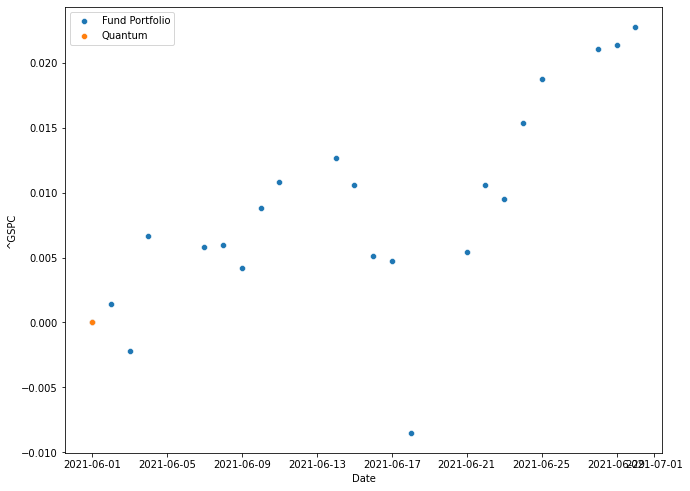


Run completed.

idx: 2021-06-02 00:00:00
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-02 00:00:00
self.position: 103
self.initial_position: 2021-05-25T00:00:00.000000000
sum price: 85341.07778549194
sum daily returns: 5.203915130056197
avg daily returns: 0.0874877346784887
covariance_matrix sum: 3.0698479950284816
correlation_matrix sum: 16834.395713444697
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 81
solution_stocks: {'A': 3, 'AAL': 76, 'AAP': 13, 'AAPL': 0, 'ABBV': 7, 'ABC': 2, 'ABMD': 1, 'ABT': 16, 'ACGL': 3, 'ACN': 27, 'ADBE': 1, 'ADI': 0, 'ADM': 40, 'ADP': 27, 'ADSK': 21, 'AEE': 11, 'AEP': 5, 'AES': 101, 'AFL': 1, 'AIG': 2, 'AIZ': 1, 'AJG': 4, 'AKAM': 47, 'ALB': 4, 'ALGN': 0, 'ALK': 2, 'ALL': 0, 'ALLE': 15, 'AMAT': 84, 'AMCR': 526, 'AMD': 24, 'AME': 11, 'AMGN': 6, 'AMP': 1, 'AMT': 4, 'AMZN': 1, 'ANET': 15, 'ANSS': 3, 'AON': 0, 'AOS': 58, 'APA': 33, 'APD': 19, 'APH': 25, 'APTV': 1, 'ARE': 58, 'ATO': 5,

,idx,variance,returns,value,value_norm
0,2021-06-01,58.09,-326.36,9.989933e+05,0.000000
0,2021-06-02,4167.23,170.61,1.000922e+06,0.001931


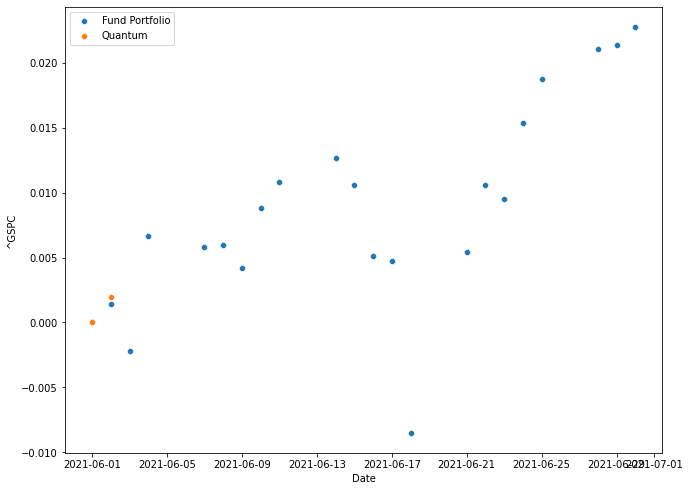


Run completed.

idx: 2021-06-03 00:00:00
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-03 00:00:00
self.position: 104
self.initial_position: 2021-05-26T00:00:00.000000000
sum price: 85001.14899158478
sum daily returns: 6.616889357286645
avg daily returns: 0.4260744600253207
covariance_matrix sum: 1.5877871802192913
correlation_matrix sum: 7542.365248501148
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 80
solution_stocks: {'A': 50, 'AAL': 4, 'AAP': 0, 'AAPL': 0, 'ABBV': 0, 'ABC': 16, 'ABMD': 8, 'ABT': 480, 'ACGL': 3, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 1, 'ADP': 19, 'ADSK': 0, 'AEE': 15, 'AEP': 38, 'AES': 25, 'AFL': 1, 'AIG': 17, 'AIZ': 0, 'AJG': 1, 'AKAM': 19, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 8, 'ALLE': 24, 'AMAT': 61, 'AMCR': 327, 'AMD': 12, 'AME': 3, 'AMGN': 2, 'AMP': 9, 'AMT': 0, 'AMZN': 0, 'ANET': 0, 'ANSS': 0, 'AON': 2, 'AOS': 7, 'APA': 104, 'APD': 0, 'APH': 23, 'APTV': 70, 'ARE': 0, 'ATO': 0, 'ATV

,idx,variance,returns,value,value_norm
0,2021-06-01,58.09,-326.36,9.989933e+05,0.000000
0,2021-06-02,4167.23,170.61,1.000922e+06,0.001931
0,2021-06-03,15.88,1292.00,9.971426e+05,-0.001853


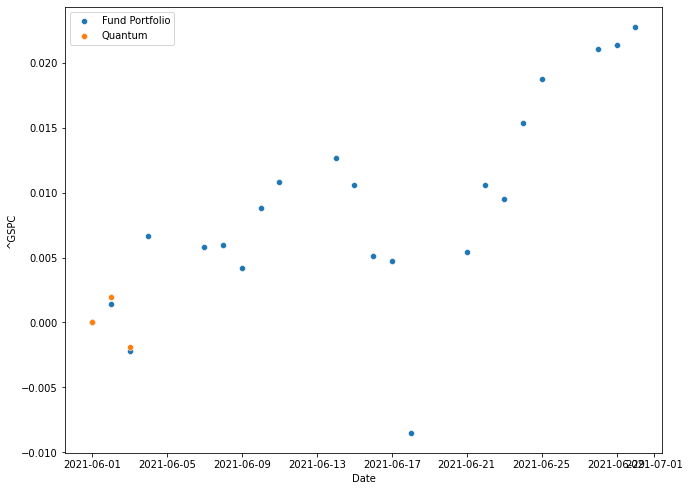


Run completed.

idx: 2021-06-04 00:00:00
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-04 00:00:00
self.position: 105
self.initial_position: 2021-05-27T00:00:00.000000000
sum price: 85622.25078010559
sum daily returns: 7.358264998442357
avg daily returns: -0.32846656929201035
covariance_matrix sum: 1.957488505434716
correlation_matrix sum: 10507.917132151793
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 80
solution_stocks: {'A': 0, 'AAL': 18, 'AAP': 5, 'AAPL': 32, 'ABBV': 13, 'ABC': 4, 'ABMD': 0, 'ABT': 6, 'ACGL': 78, 'ACN': 15, 'ADBE': 0, 'ADI': 12, 'ADM': 1, 'ADP': 10, 'ADSK': 0, 'AEE': 33, 'AEP': 3, 'AES': 46, 'AFL': 37, 'AIG': 94, 'AIZ': 4, 'AJG': 1, 'AKAM': 18, 'ALB': 4, 'ALGN': 0, 'ALK': 0, 'ALL': 13, 'ALLE': 5, 'AMAT': 0, 'AMCR': 77, 'AMD': 4, 'AME': 11, 'AMGN': 0, 'AMP': 3, 'AMT': 0, 'AMZN': 0, 'ANET': 10, 'ANSS': 0, 'AON': 19, 'AOS': 5, 'APA': 12, 'APD': 2, 'APH': 14, 'APTV': 0, 'ARE': 0, 'ATO': 41, '

,idx,variance,returns,value,value_norm
0,2021-06-01,58.09,-326.36,9.989933e+05,0.000000
0,2021-06-02,4167.23,170.61,1.000922e+06,0.001931
0,2021-06-03,15.88,1292.00,9.971426e+05,-0.001853
0,2021-06-04,129.15,-304.93,1.003191e+06,0.004202


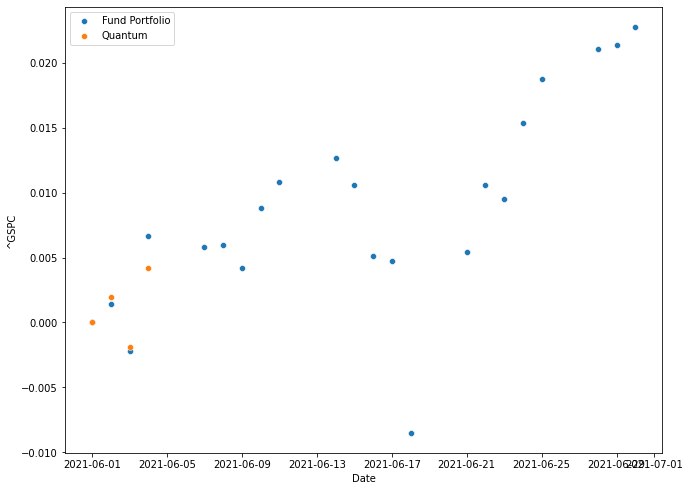


Run completed.

idx: 2021-06-07 00:00:00
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-07 00:00:00
self.position: 106
self.initial_position: 2021-05-28T00:00:00.000000000
sum price: 85461.06791305542
sum daily returns: 4.035885178639798
avg daily returns: 0.6906335670577742
covariance_matrix sum: 2.1196082642952914
correlation_matrix sum: 16945.823001018965
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 75
solution_stocks: {'A': 2, 'AAL': 58, 'AAP': 0, 'AAPL': 0, 'ABBV': 1, 'ABC': 2, 'ABMD': 0, 'ABT': 67, 'ACGL': 16, 'ACN': 0, 'ADBE': 0, 'ADI': 0, 'ADM': 18, 'ADP': 7, 'ADSK': 0, 'AEE': 92, 'AEP': 13, 'AES': 17, 'AFL': 69, 'AIG': 1, 'AIZ': 6, 'AJG': 0, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 101, 'ALL': 47, 'ALLE': 14, 'AMAT': 0, 'AMCR': 205, 'AMD': 15, 'AME': 20, 'AMGN': 1, 'AMP': 0, 'AMT': 18, 'AMZN': 0, 'ANET': 2, 'ANSS': 0, 'AON': 2, 'AOS': 5, 'APA': 61, 'APD': 10, 'APH': 114, 'APTV': 0, 'ARE': 10, 'ATO': 46,

,idx,variance,returns,value,value_norm
0,2021-06-01,58.09,-326.36,9.989933e+05,0.000000
0,2021-06-02,4167.23,170.61,1.000922e+06,0.001931
0,2021-06-03,15.88,1292.00,9.971426e+05,-0.001853
0,2021-06-04,129.15,-304.93,1.003191e+06,0.004202
0,2021-06-07,5367.99,4204.92,1.000843e+06,0.001851


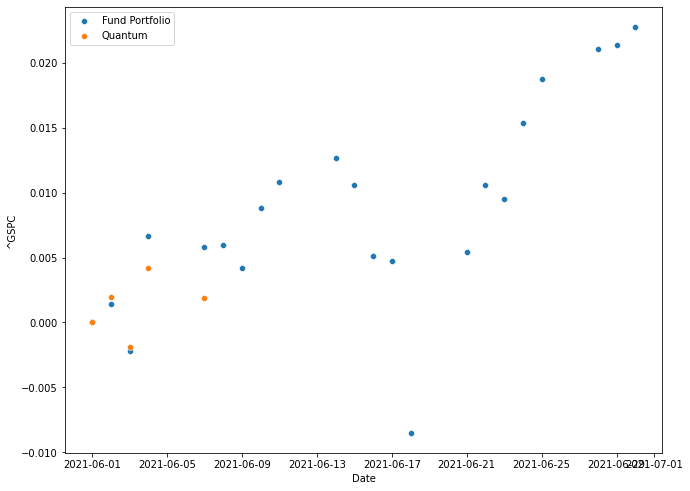


Run completed.

idx: 2021-06-08 00:00:00


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-08 00:00:00
self.position: 107
self.initial_position: 2021-06-01T00:00:00.000000000
sum price: 85699.79977607727
sum daily returns: 4.261388254961581
avg daily returns: 0.13924979831569506
covariance_matrix sum: 2.125464028359065
correlation_matrix sum: 16073.98079452047
t_cost True
t_cost: 0.001
upper bound = budget: 0.0
init_budget: 1000000
lower bound: -3000.0
n_samples: 76
solution_stocks: {'A': 0, 'AAL': 20, 'AAP': 0, 'AAPL': 5, 'ABBV': 2, 'ABC': 4, 'ABMD': 0, 'ABT': 175, 'ACGL': 4, 'ACN': 0, 'ADBE': 0, 'ADI': 24, 'ADM': 10, 'ADP': 7, 'ADSK': 0, 'AEE': 19, 'AEP': 51, 'AES': 61, 'AFL': 77, 'AIG': 56, 'AIZ': 8, 'AJG': 28, 'AKAM': 0, 'ALB': 0, 'ALGN': 0, 'ALK': 0, 'ALL': 26, 'ALLE': 13, 'AMAT': 0, 'AMCR': 628, 'AMD': 3, 'AME': 22, 'AMGN': 3, 'AMP': 2, 'AMT': 11, 'AMZN': 3, 'ANET': 55, 'ANSS': 0, 'AON': 14, 'AOS': 27, 'APA': 76, 'APD': 7, 'APH': 8, 'APTV': 0, 'ARE': 9, 'ATO': 0, 'ATVI': 0, 'AVB': 3, 'AVGO': 0, 'AVY': 0, 'A

,idx,variance,returns,value,value_norm
0,2021-06-01,58.09,-326.36,9.989933e+05,0.000000
0,2021-06-02,4167.23,170.61,1.000922e+06,0.001931
0,2021-06-03,15.88,1292.00,9.971426e+05,-0.001853
0,2021-06-04,129.15,-304.93,1.003191e+06,0.004202
0,2021-06-07,5367.99,4204.92,1.000843e+06,0.001851
0,2021-06-08,460.82,736.32,1.002751e+06,0.003762


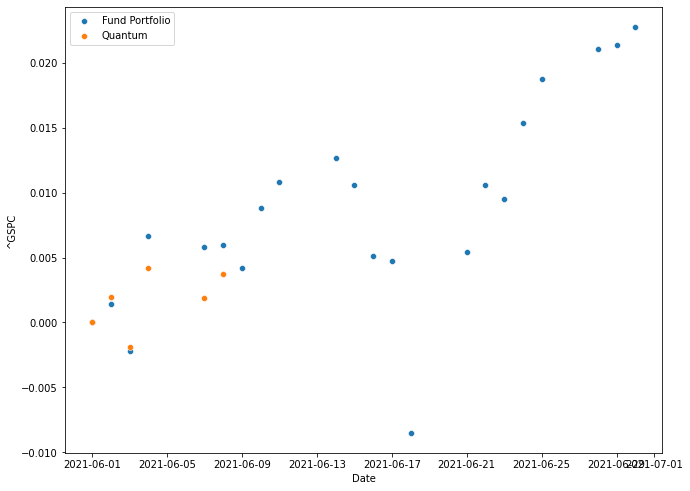


Run completed.

idx: 2021-06-09 00:00:00
new purchase budget: 0.0, initial_budget: 1000000
idx: 2021-06-09 00:00:00
self.position: 108
self.initial_position: 2021-06-02T00:00:00.000000000
sum price: 85414.82537078857
sum daily returns: 0.3804286634656009
avg daily returns: 0.323607068484837
covariance_matrix sum: 2.9265612805978036
correlation_matrix sum: 23447.891286821297


In [ ]:
print('initial df')
display(df.head())

# if not init_holdings_path: 
#     init_holdings_df, budget = generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget)
#     init_holdings_df.to_pickle(save_path+'init_holdings.pkl')
# else:
#     init_holdings_df = pd.read_pickle(init_holdings_path)
#     prices = df.loc[dates[0], :].values.tolist()
#     #print('init holdings df')
#     #display(init_holdings_df.head())
#     #print(f'prices: {prices}')
#     pop = init_holdings_df['b'].values.tolist()
#     #print(f'pop: {pop}')
#     budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])
#     print(f'GA budget: {budget}')

# init_holdings = {}
# for idx, row in init_holdings_df.iterrows():
#     init_holdings.update({row['a']: row['b']})
init_holdings = {s:0 for s in stocks}

#print(f'init_holdings: {init_holdings}')
#print(f'new budget: {budget}')
  
# checking if the directory demo_folder 
# exist or not.
if not os.path.exists(save_path+label):
    os.makedirs(save_path+label)

my_portfolio = MultiPeriod(data=df,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=sampler_args,
                        dates=dates,
                        file_path=file_path,
                        model_type=model_type,
                        alpha=alpha,
                        verbose=verbose,
                        t_cost=t_cost,
                        label=label,
                        init_holdings=init_holdings,
                        save_path=save_path+label+'/'
                        )

my_portfolio.run(min_return=min_return, max_risk=max_risk, num=num)